## Logistic regression
---
I'm using [this](https://www.kaggle.com/uciml/pima-indians-diabetes-database) dataset from UCI to try and predict whether a patient will develop diabetes. This is a binary classification tasks, with the target being either 0 (no diabetes) or 1 (onset of diabetes).

In [33]:
import numpy as np # linear algebra
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # visualisation
import altair as alt
import seaborn as sns
import eli5
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, plot_confusion_matrix

In [34]:
diabetes_df = pd.read_csv('../data/diabetes-classification.csv')

diabetes_df.columns = [col.lower() for col in diabetes_df.columns]

First let's investigate our data. We have 7 predictive features and one target variable:
- pregnancies: number of pregnancies of the patient (they are all female)
- glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- bloodpressure: Diastolic blood pressure (mm Hg)
- skinthickness: the skin thickness in mm at the tricep fold, a proxy indicator for BMI/obesity
- insulin: 2-Hour serum insulin (mu U/ml)
- bmi: body mass index (weight in kg)/((height in metres)^2)
- age: age in years
- outcome: 0 or 1

## Investigating the data
---
First, let's see what the columns look like:

In [11]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   768 non-null    int64  
 2   bloodpressure             768 non-null    int64  
 3   skinthickness             768 non-null    int64  
 4   insulin                   768 non-null    int64  
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


How well do my features correlate?

In [9]:
diabetes_df.corr()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
bloodpressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skinthickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
diabetespedigreefunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


OK, much less correlated than in the other dataset, which means we have a shot at a good prediction here.

## Data visualisation
---

In [4]:
# plt.figure(figsize=(12, 7))
# sns.boxplot(data=diabetes_df, x='outcome', y='bmi', palette='BuPu')

alt.Chart(diabetes_df).mark_bar().encode(
    x = 'outcome:O',
    y = 'count()'
).properties(width=150)

alt.Chart(...)

In [5]:
alt.Chart(diabetes_df).mark_bar(width=10).encode(
    alt.X('pregnancies:Q'),
    alt.Y('count():Q'))

alt.Chart(...)

In [6]:
alt.Chart(diabetes_df[diabetes_df['outcome']==1]).mark_bar().encode(
    x = alt.X('age:Q'),
    y = alt.Y('count():Q'),
    tooltip = [alt.Tooltip('age:Q'),
              alt.Tooltip('count()')]
). properties(
                                width=600,
                                height=300)

alt.Chart(...)

Diabetes is most prevalent in this dataset for people of age 25, 29, 31, 41.

## Splitting the data and training the models
---

In [31]:
X = diabetes_df.drop(['outcome', 'age', 'skinthickness'], axis=1)
y = diabetes_df['outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

Now let's train the model, then generate some predictions and evaluate.

newton-cg
-----------------


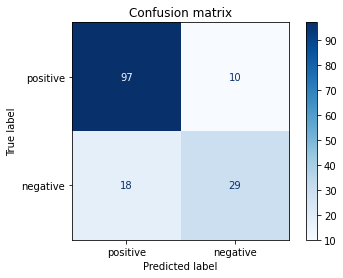

Accuracy: 0.8181818181818182
Precision: 0.7435897435897436
Recall: 0.6170212765957447
ROC AUC: 0.7617816663352556 

lbfgs
-----------------


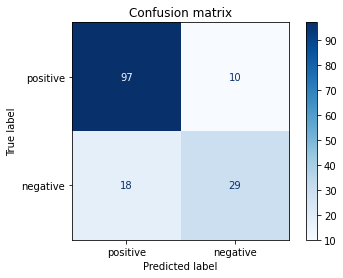

Accuracy: 0.8181818181818182
Precision: 0.7435897435897436
Recall: 0.6170212765957447
ROC AUC: 0.7617816663352556 

liblinear
-----------------


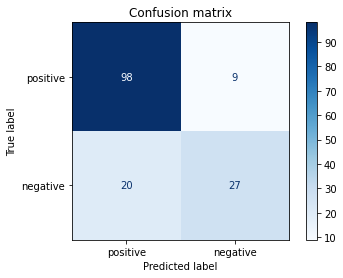

Accuracy: 0.8116883116883117
Precision: 0.75
Recall: 0.574468085106383
ROC AUC: 0.7451779677868364 

sag
-----------------


/Users/inwaves/anaconda3/envs/my_first_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


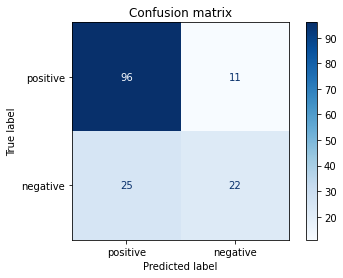

Accuracy: 0.7662337662337663
Precision: 0.6666666666666666
Recall: 0.46808510638297873
ROC AUC: 0.6826406840326108 

saga
-----------------


/Users/inwaves/anaconda3/envs/my_first_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


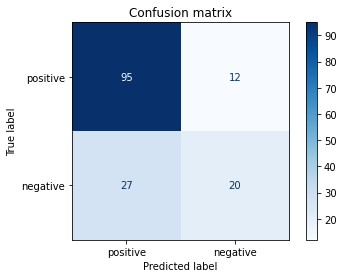

Accuracy: 0.7467532467532467
Precision: 0.625
Recall: 0.425531914893617
ROC AUC: 0.6566911910916683 



Weight,Feature
0.1377 ± 0.0516,glucose
0.0325 ± 0.0296,pregnancies
0.0208 ± 0.0380,bmi
0.0143 ± 0.0151,diabetespedigreefunction
0.0026 ± 0.0211,bloodpressure


Weight,Feature
0.1377 ± 0.0516,glucose
0.0325 ± 0.0296,pregnancies
0.0208 ± 0.0380,bmi
0.0143 ± 0.0151,diabetespedigreefunction
0.0026 ± 0.0211,bloodpressure


Weight,Feature
0.1442 ± 0.0553,glucose
0.0429 ± 0.0292,pregnancies
0.0208 ± 0.0289,bmi
0.0065 ± 0.0142,diabetespedigreefunction
0.0065 ± 0.0394,bloodpressure


Weight,Feature
0.1117 ± 0.0600,glucose
0.0468 ± 0.0208,pregnancies
0.0039 ± 0.0132,diabetespedigreefunction
-0.0026 ± 0.0424,bloodpressure
-0.0065 ± 0.0232,bmi


Weight,Feature
0.0987 ± 0.0855,glucose
0.0312 ± 0.0301,pregnancies
-0.0065 ± 0.0184,bmi
-0.0091 ± 0.0132,diabetespedigreefunction
-0.0130 ± 0.0472,bloodpressure


In [32]:
def print_results(lin_model, predictions_lin_model, solver):
    print(solver)
    print("-----------------")
    disp = plot_confusion_matrix(lin_model, X_test, y_test,
                                display_labels=['positive', 'negative'],
                                cmap=plt.cm.Blues,
                                values_format= '.0f')
    disp.ax_.set_title("Confusion matrix")
    plt.show()
    print("Accuracy: {}".format(accuracy_score(y_test, predictions_lin_model)))
    print("Precision: {}".format(precision_score(y_test, predictions_lin_model)))
    print("Recall: {}".format(recall_score(y_test, predictions_lin_model)))
    print("ROC AUC: {} \n".format(roc_auc_score(y_test, predictions_lin_model)))

def parameterise_model(solver, C=1.0, max_iter=100):
    lin_model = LogisticRegression(solver=solver, random_state=0,
                              C=C, max_iter=max_iter)
    lin_model.fit(X_train, y_train)
    return lin_model

weights = []
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    lin_model = parameterise_model(solver, C=0.8,
                                    max_iter=1000)
    
    # Looking at permutation importance for each label
    perm_importance = eli5.sklearn.PermutationImportance(lin_model,
                                                        random_state=1).fit(X_test, y_test)
    weights.append(eli5.show_weights(perm_importance, feature_names = X_test.columns.tolist()))

    predictions_lin_model = lin_model.predict(X_test)
    print_results(lin_model, predictions_lin_model, solver)
    
for display_weights in weights:
    display(display_weights)
    

newton-cg and lbfgs stand out as the best performers, but not by far. Decreasing C, the inverse of the regularisation strength, results in worse performance across the board.